# Dataset

In [41]:
import torch
from torch.utils import data
import ast
import pandas as pd
import numpy as np

class ClusterDataset(data.Dataset):
    def __init__(self, csv_file, group, sequence_length=15, future_steps=1):
        """
        Args:
            csv_file (str): Path to the modified clusters CSV file.
            sequence_length (int): Number of steps in each sequence for training.
        """
        self.sequence_length = sequence_length
        self.future_steps = future_steps
        df = pd.read_csv(csv_file)

        # Filter by group and sort by start_date
        df = df[df['group'] == group].copy()
        df['start_date'] = pd.to_datetime(df['start_date'])
        df = df.sort_values(by='start_date')
        
        # Group by start_date to create sets of clusters for each timestep
        self.sequence = []
        for start_date, group_df in df.groupby('start_date'):
            clusters = group_df[['lat', 'lon', 'volume']].values
            self.sequence.append((start_date, clusters))

        self.max_clusters = max(len(clusters) for _, clusters in self.sequence)
    def __len__(self):
        return max(0, len(self.sequence) - self.sequence_length - self.future_steps)

    def __getitem__(self, idx):
        """
        Returns a sequence of cluster sets for training.
        Each sequence step is padded to the same length.
        """
        input_sequence = [clusters for _, clusters in self.sequence[idx:idx + self.sequence_length]]
        target_sequence = [clusters for _, clusters in self.sequence[idx + self.sequence_length + 1:idx + self.sequence_length + 1 + self.future_steps]]

        return self.pad_sequence(input_sequence), self.pad_sequence(target_sequence), torch.tensor(len(target_sequence[0]), dtype=torch.float32)

    def pad_sequence(self, sequence):
        """
        Pads a variable-length sequence of sets to the maximum number of clusters in the sequence.
        Each set is padded with (0.0, 0.0, 0.0) until it reaches the max length.
        """
        padded_sequence = []
        for step in sequence:
            # Pad each step with (0.0, 0.0, 0.0) until it reaches max_clusters length
            if len(step) < self.max_clusters:
                padded_step = np.pad(step, ((0, self.max_clusters - len(step)), (0, 0)), mode='constant', constant_values=0.0)
                padded_sequence.append(padded_step)
            else:
                padded_sequence.append(step)

        return torch.tensor(padded_sequence, dtype=torch.float32)  # Shape: (sequence_length, max_clusters, 3)

In [42]:
test_dataset = ClusterDataset("data/clusters.csv", sequence_length=30, group='infrastructure', future_steps=1)
print(len(test_dataset))
print(test_dataset[0])
dataloader = data.DataLoader(test_dataset, batch_size=4, shuffle=True)

17
(tensor([[[43.7268, 10.3930,  2.0000],
         [43.7220, 10.3897,  7.0000],
         [43.7202, 10.4003,  3.0000],
         [43.7227, 10.3939,  5.0000]],

        [[43.7268, 10.3930,  2.0000],
         [43.7220, 10.3897,  7.0000],
         [43.7202, 10.4003,  3.0000],
         [43.7227, 10.3939,  5.0000]],

        [[43.7221, 10.3897,  8.0000],
         [43.7268, 10.3930,  2.0000],
         [43.7198, 10.4003,  2.0000],
         [43.7227, 10.3939,  5.0000]],

        [[43.7227, 10.3936,  4.0000],
         [43.7198, 10.4003,  2.0000],
         [43.7266, 10.3925,  4.0000],
         [43.7221, 10.3897,  8.0000]],

        [[43.7222, 10.3896,  9.0000],
         [43.7262, 10.3923,  5.0000],
         [43.7198, 10.4003,  2.0000],
         [43.7226, 10.3957,  6.0000]],

        [[43.7223, 10.3917, 16.0000],
         [43.7262, 10.3923,  5.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[43.7224, 10.3918, 18.0000],
         [43.7261, 10.3921,  6.000

# LSTM model

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#############################################
# 1. DeepSets Encoder for a single time step
#############################################

class DeepSetEncoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=64):
        """
        Encodes a set of clusters (each with `input_dim` features) into a fixed-length vector.
        """
        super(DeepSetEncoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        """
        x: Tensor of shape (batch, num_clusters, 3)
        """
        embed = self.mlp(x)
        return torch.mean(embed, dim=2)  # Average the embeddings of all clusters

#############################################
# 2. LSTM Forecaster for temporal prediction
#############################################

class ForecastModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_hidden_dim, future_steps=1, max_clusters=10):
        super(ForecastModel, self).__init__()
        self.future_steps = future_steps
        self.max_clusters = max_clusters
        self.input_dim = input_dim

        self.deepset = DeepSetEncoder(input_dim, hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden_dim, num_layers=9, batch_first=True)
        
        self.cluster_count_predictor = nn.Sequential(
            nn.Linear(lstm_hidden_dim, 1),
            nn.LeakyReLU()
        )
        self.cluster_decoder = nn.Sequential(
            nn.Linear(lstm_hidden_dim, lstm_hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(lstm_hidden_dim, max_clusters * input_dim)
        )  # Predict cluster properties

    def forward(self, x):
        aggregated = self.deepset(x)
        lstm_out, _ = self.lstm(aggregated)
        # Predict the number of clusters
        num_clusters = self.cluster_count_predictor(lstm_out[:, -1, :])
        
        # Predict cluster properties for each cluster
        cluster_predictions = self.cluster_decoder(lstm_out[:, -1, :])
        cluster_predictions = cluster_predictions.view(-1, self.max_clusters, self.input_dim)
        # Mask out predictions for non-existent clusters
        mask = torch.arange(self.max_clusters, device=cluster_predictions.device).unsqueeze(0) < num_clusters.round()
        cluster_predictions = cluster_predictions * mask.unsqueeze(-1).float()
        cluster_predictions = torch.where(cluster_predictions == 0, torch.tensor(0.0, device=cluster_predictions.device), cluster_predictions)
        
        return torch.squeeze(num_clusters), torch.unsqueeze(cluster_predictions, 1)

# Train

In [44]:
import torch
import math

def haversine_loss(pred_coords, target_coords):
    """
    Computes the mean Haversine distance between predicted and target coordinates.
    
    Both pred_coords and target_coords should be tensors of shape (..., 2)
    where the last dimension is [latitude, longitude] in degrees.
    """
    R = 6371000.0  # Earth's radius in meters
    # Convert degrees to radians
    pred_rad = pred_coords * math.pi / 180.0
    target_rad = target_coords * math.pi / 180.0
    
    # Difference in coordinates
    dlat = pred_rad[..., 0] - target_rad[..., 0]
    dlon = pred_rad[..., 1] - target_rad[..., 1]
    
    # Haversine formula
    a = torch.sin(dlat/2)**2 + torch.cos(pred_rad[..., 0]) * torch.cos(target_rad[..., 0]) * torch.sin(dlon/2)**2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1-a))
    distances = R * c  # distance in meters
    
    return torch.mean(distances)

In [45]:
import torch
import torch.optim as optim
import torch.nn as nn

max_clusters = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ForecastModel(input_dim=3, 
                      hidden_dim=512,
                      lstm_hidden_dim=1024,
                      future_steps=1,
                      max_clusters=max_clusters)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00002)
loss_fn = nn.MSELoss()
loss2_fn = nn.MSELoss()
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    mape_acc = 0.0
    num_batches = 0
    for batch_inputs, batch_targets, true_num_clusters in dataloader:
        model.train()
        # Move data to device
        batch_inputs = batch_inputs.to(device)    
        batch_targets = batch_targets.to(device)     
        true_num_clusters = true_num_clusters.to(device)

        n_clusters, predictions = model(batch_inputs)

        mask = torch.arange(max_clusters, device=device).unsqueeze(0) < torch.min(n_clusters.round(), true_num_clusters).unsqueeze(-1)
        batch_targets = batch_targets * mask.unsqueeze(1).unsqueeze(-1).float()  
        predictions = predictions * mask.unsqueeze(1).unsqueeze(-1).float()


        cluster_loss = loss_fn(predictions, batch_targets)
        num_clusters_loss = loss2_fn(n_clusters, true_num_clusters)
        
        preds_coords = predictions.squeeze(1)[..., :2]  # shape: (batch, max_clusters, 2)
        targets_coords = batch_targets.squeeze(1)[..., :2]

        valid_mask = mask.bool()  # shape: (batch, max_clusters, 1)
        valid_pred_coords = preds_coords[valid_mask].view(-1, 2)      # shape: (N, 2)
        valid_target_coords = targets_coords[valid_mask].view(-1, 2)

        if valid_pred_coords.numel() > 0:
            hav_loss = haversine_loss(valid_pred_coords, valid_target_coords)
        else:
            hav_loss = torch.tensor(0.0, device=device)

        # Total loss is a weighted combination of both
        total_loss = (hav_loss**2 + num_clusters_loss*10 + cluster_loss*100) / 3

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        """ print(n_clusters, true_num_clusters)
        print(predictions, batch_targets) """

        epoch_loss += total_loss.item()
        mape_acc += max(1 - torch.mean(torch.abs((predictions - batch_targets) / (batch_targets + 1e-8))), 0)
        num_batches += 1
    avg_acc = mape_acc / num_batches
    avg_loss = epoch_loss / num_batches

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f} Accuracy: { avg_acc.item():.4f}")

e:\citysentry-server\citysentry\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/300, Loss: 25.0110 Accuracy: 1.0000
Epoch 2/300, Loss: 24.4403 Accuracy: 1.0000
Epoch 3/300, Loss: 23.8134 Accuracy: 1.0000
Epoch 4/300, Loss: 22.9349 Accuracy: 1.0000
Epoch 5/300, Loss: 19.1644 Accuracy: 1.0000
Epoch 6/300, Loss: 4949204271110.0547 Accuracy: 0.8496
Epoch 7/300, Loss: 8222560537804.7998 Accuracy: 0.7493
Epoch 8/300, Loss: 8138751842713.5996 Accuracy: 0.7007
Epoch 9/300, Loss: 8055547022540.7998 Accuracy: 0.3799
Epoch 10/300, Loss: 7878449561600.0000 Accuracy: 0.3246
Epoch 11/300, Loss: 7646922932224.0000 Accuracy: 0.3336
Epoch 12/300, Loss: 7377494160179.2002 Accuracy: 0.3440
Epoch 13/300, Loss: 7082832140697.5996 Accuracy: 0.3576
Epoch 14/300, Loss: 6761347022848.0000 Accuracy: 0.3737
Epoch 15/300, Loss: 6371674056294.4004 Accuracy: 0.4268
Epoch 16/300, Loss: 6084836510924.7998 Accuracy: 0.4140
Epoch 17/300, Loss: 5741823079219.2002 Accuracy: 0.4357
Epoch 18/300, Loss: 5343740113715.2002 Accuracy: 0.4944
Epoch 19/300, Loss: 5074135600332.7998 Accuracy: 0.4942


KeyboardInterrupt: 

# Testing

In [ ]:
test_dataset = ClusterDataset("data/clusters.csv", sequence_length=35, group='infrastructure', future_steps=1)
test_loader = data.DataLoader(test_dataset, batch_size=40, shuffle=True)

import torch

# Set your device and ensure your model is loaded/trained
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # switch to evaluation mode

mape_total = 0.0
num_batches = 0

with torch.no_grad():
    for batch_inputs, batch_targets, true_num_clusters in test_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        true_num_clusters = true_num_clusters.to(device)
        
        n_clusters, predictions = model(batch_inputs)

        mask = torch.arange(max_clusters, device=device).unsqueeze(0) < torch.min(n_clusters.round(), true_num_clusters).unsqueeze(-1)
        batch_targets = batch_targets * mask.unsqueeze(1).unsqueeze(-1).float()  
        predictions = predictions * mask.unsqueeze(1).unsqueeze(-1).float()

                # Compute the Mean Absolute Percentage Error (MAPE)
        mape = max(1 - torch.mean(torch.abs((predictions - batch_targets) / (batch_targets + 1e-8))), 0)
        mape_total += mape.item()
        num_batches += 1
        print(predictions, batch_targets)

avg_mape = mape_total / num_batches
print(f"Test MAPE: {avg_mape:.2f}%")

tensor([[[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3923,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
 

tensor([[[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3923,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
          [43.7223, 10.3922,  4.3597],
          [43.7223, 10.3920,  2.9302],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[43.7222, 10.3959,  4.5345],
 

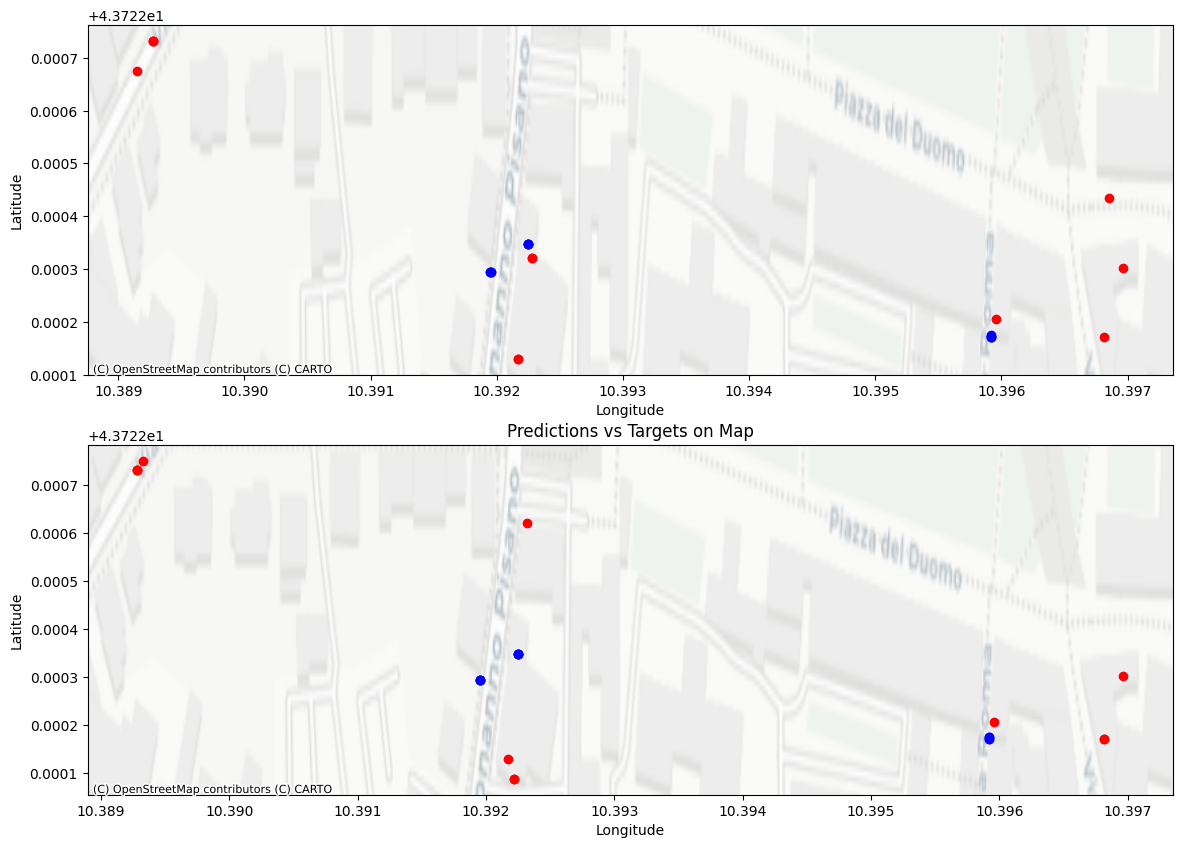

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# Convert predictions and targets to numpy for plotting
predictions_np = predictions.detach().cpu().numpy().reshape(-1, 3)  # Reshape to (N, 3)
targets_np = batch_targets.detach().cpu().numpy().reshape(-1, 3)
print(predictions)
# Separate latitude, longitude, and cluster properties
pred_lat, pred_lon = predictions_np[:, 0], predictions_np[:, 1]
target_lat, target_lon = targets_np[:, 0], targets_np[:, 1]

# Filter out the padded values (i.e., clusters with [0.0, 0.0])
valid_pred_mask = (pred_lat != 0) & (pred_lon != 0)
valid_target_mask = (target_lat != 0) & (target_lon != 0)

# Apply the masks to filter out the padded clusters
pred_lat = pred_lat[valid_pred_mask]
pred_lon = pred_lon[valid_pred_mask]
target_lat = target_lat[valid_target_mask]
target_lon = target_lon[valid_target_mask]

timesteps = len(pred_lat) // predictions.shape[0]

# Plotting
fig, ax = plt.subplots(timesteps, 1, figsize=(14, 10))
for t in range(timesteps):
    for i in range(predictions.shape[0]):  # iterate over batch samples
        # Extract the coordinates for this batch sample at timestep `t`
        pred_lat_t = pred_lat[i * timesteps + t]
        pred_lon_t = pred_lon[i * timesteps + t]
        target_lat_t = target_lat[i * timesteps + t]
        target_lon_t = target_lon[i * timesteps + t]
        
        # Plot predictions as blue points
        ax[t].scatter(pred_lon_t, pred_lat_t, color='blue', label=f"Predicted T{t+1}" if t == 0 else "")
        
        # Plot targets as red points
        ax[t].scatter(target_lon_t, target_lat_t, color='red', label=f"Target T{t+1}" if t == 0 else "")
    ax[t].set_xlabel("Longitude")
    ax[t].set_ylabel("Latitude")
    ctx.add_basemap(ax[t], crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)

""" print("Target Coordinates (Lat, Lon):")
for i in range(len(target_lat)):
    print(f"Target {i+1}: ({target_lat[i]:.4f}, {target_lon[i]:.4f})")

print("\nPrediction Coordinates (Lat, Lon):")
for i in range(len(pred_lat)):
    print(f"Prediction {i+1}: ({pred_lat[i]:.4f}, {pred_lon[i]:.4f})") """


# Add a basemap
  # EPSG:4326 is for latitude/longitude

# Customize the plot

plt.title("Predictions vs Targets on Map")
plt.show()